# This notebook is to extract feature importance from ML and use it to identify critical genes

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
import seaborn as sns
import networkx as nx
from sys import platform 
from src.eda.subset_network import subset_network
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.embedding.network_embedding import network_embedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [310]:
from src.models.ML_functions import *

In [311]:
emb_len16_walk300 = pd.read_csv('C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1/embedded_len64_walk300_cluster3+4.csv', index_col = 0)

In [313]:
processed_emb = process_emb_for_ML(emb_len16_walk300)

## Run ML 

In [30]:
lr = LogisticRegression(max_iter = 1000)
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [318]:
num_sample = processed_emb.impact.value_counts().min()
emb_subset = processed_emb.groupby('impact').sample(num_sample).reset_index() # subset to have equal samples in the two classes
X_train, X_test, y_train, y_test = train_test_split(emb_subset.iloc[:, :64], emb_subset['impact'], test_size = 0.2)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [319]:
print('lr accuracy', lr.score(X_test, y_test))
print('rf accuracy', rf.score(X_test, y_test))
xgb_predict = xgb.predict(X_test)
print('xgb accuracy', accuracy_score(y_test, xgb_predict))

lr accuracy 0.6528497409326425
rf accuracy 0.7202072538860104
xgb accuracy 0.7098445595854922


In [332]:
type(lr).__name__ == 'LogisticRegression'

True

In [334]:
def get_important_features(model):
    '''Get feature importances from models'''
    if type(model).__name__ == 'LogisticRegression':
        coef = lr.coef_[0]
        coef = np.abs(lr_coef) # convert coef to positive values only
        coef /= np.sum(lr_coef) # convert coef to % importance
    else:
        coef = model.feature_importances_
    return coef

In [336]:
model_feature_importances = list(map(get_important_features, [lr, rf, xgb]))

In [343]:
def get_min_max_center(coef):
    '''A function to get min, max and avg used for heatmap in plot_feature_importances()'''
    min_value = coef.min()
    max_value = coef.max()
    center = np.mean([min_value, max_value])
    return min_value, max_value, center

In [349]:
def plot_feature_importances(model_coefs, model_names):
    '''A function to show feature importances in each model'''
    plt.figure(figsize = (7, 10))
    i = 0
    for coef in model_coefs:
        min_v, max_v, center = get_min_max_center(coef)
        plt.subplot(1,3,i+1)
        sns.heatmap(coef.reshape(64, 1), center = center, vmin = min_v, vmax = max_v)
        plt.title(model_names[i])
        plt.subplots_adjust(wspace = 2)
        i += 1

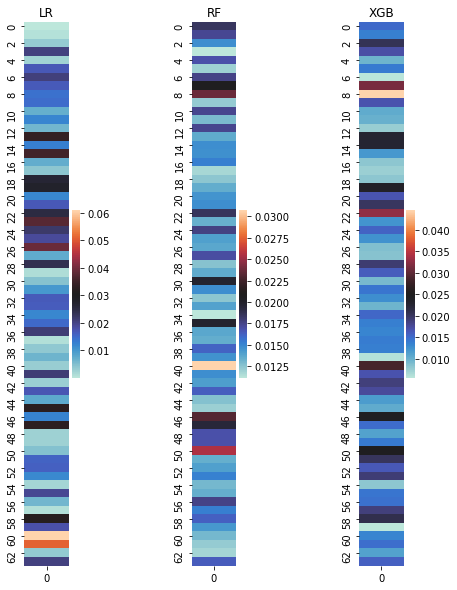

In [350]:
plot_feature_importances(model_feature_importances, ['LR', 'RF', 'XGB'])

## Extract top 20% important features 

In [369]:
def get_top_dim(processed_emb_df, coef, top_n_coef = 0.2):
    '''
    Get the top features used for each ML and return as a list along with id and abs_log2FC for the get_pairwise_distances()
    top_n_coef: 0.2 means extract features up to 20% importance
    '''
    for i in range(1, 64):
        if np.sum(coef[coef.argsort()[-i:]]) > top_n_coef:
            num_dim = i
            break 
    top_dim = [str(num) for num in coef.argsort()[-num_dim:]]
    top_dim += ['id', 'abs_log2FC']
    emb_top_features = processed_emb_df[top_dim]
    return emb_top_features

In [453]:
top_feature_list = list(map(get_top_dim, processed_emb, model_feature_importances))

In [135]:
from sklearn.metrics.pairwise import euclidean_distances as ed

In [372]:
def get_pairwise_distances(processed_emb_df):
    '''Determine pairwise euclidean distance between each data point'''
    pairwise_distances = pd.DataFrame(ed(processed_emb_df.iloc[:, :-2]))
    pairwise_distances.columns = processed_emb_df['id']
    pairwise_distances.index = processed_emb_df['id']
    pairwise_distances['abs_log2FC'] = processed_emb_df['abs_log2FC'].tolist()
    pairwise_distances.sort_values('abs_log2FC', ascending = False, inplace=True)
    return pairwise_distances

In [458]:
pairwise_distance_list = list(map(get_pairwise_distances, [processed_emb[features] for features in top_feature_list]))

In [202]:
from collections import Counter

In [439]:
def get_critical_genes(pairwise_distance_df):
    '''
    Find critical genes that are close to impact genes
    critical_gene_dict: # impact genes a critical gene is close to
    gene_pair_dict: pair the impact gene with their critical genes (based on distance) in a dictionary
    '''
    critical_gene_list = []
    gene_pair_dict = {}
    size = len(pairwise_distances[pairwise_distances.abs_log2FC > 0.2]) # cutoff of abs_log2FC > 0.2 as impact gene
    for i in range(size):
        subset_distance = pairwise_distances.iloc[i,:-2].sort_values()
        key = subset_distance[subset_distance.between(0.01,0.5)].reset_index().columns[1] # Euclidean distance < 0.5 as "close"
        values = subset_distance[subset_distance.between(0.01,0.5)].reset_index()['id'].tolist()
        gene_pair_dict[key] = values
        critical_gene_list += list(subset_distance[subset_distance.between(0.01,0.5)].index)
    critical_gene_dict = Counter(critical_gene_list)
    critical_gene_dict = sorted(critical_gene_dict.items(), key=lambda x: x[1], reverse=True)
    return critical_gene_dict, gene_pair_dict

In [463]:
# Note each item will contain 2 sets of values bc get_critical_genes return 2 sets of data
lr_critical_genes, rf_critical_genes, xgb_critical_genes = list(map(get_critical_genes, pairwise_distance_list)) 

In [465]:
def plot_critical_genes(emb_df, dim1, dim2, gene_pair_dict, critical_gene):
    plt.figure(figsize = (8,6))
    plt.scatter(emb_df[dim1], emb_df[dim2], s = 3, c = '#D3D3D3')
    for k,v in list(gene_pair_dict.items()): # loop through the distance dictionary to find the impact genes that are close to the critical genes
        if critical_gene in v:      
            plt.scatter(emb_df[emb_df.id == k][dim1], emb_df[emb_df.id == k][dim2], s = 5, c = 'b', label = 'impact gene') # Find the impact genes
    plt.scatter(emb_df[emb_df.id == critical_gene][dim1], emb_df[emb_df.id == critical_gene][dim2], s = 20, c = 'r', label = 'critical gene')
    plt.legend()

In [497]:
pd.DataFrame(rf_critical_genes[0], columns = ['id', '# impact genes close to']).head(6)

,id,# impact genes close to
0,ENSG00000100225,4
1,ENSG00000008282,3
2,ENSG00000107338,3
3,ENSG00000151726,3
4,ENSG00000176641,3
5,ENSG00000100156,3


In [479]:
def common_critical_genes(critical_gene_lists):
    '''Find common critical genes between models'''
    gene_lists = list(map(top_critical_genes, critical_gene_lists))
    return set.intersection(*map(set,gene_lists))

In [478]:
def top_critical_genes(critical_gene_list):
    return [i[0] for i in critical_gene_list[0] if i[1] >= 3]

In [480]:
common_critical_genes([lr_critical_genes, rf_critical_genes, xgb_critical_genes])

{'ENSG00000008282',
 'ENSG00000100156',
 'ENSG00000100225',
 'ENSG00000107338',
 'ENSG00000151726',
 'ENSG00000168264',
 'ENSG00000171448',
 'ENSG00000176641'}

In [483]:
top_feature_list

[['15', '23', '26', '61', '60', 'id', 'abs_log2FC'],
 ['22', '47', '30', '35', '7', '46', '8', '50', '40', 'id', 'abs_log2FC'],
 ['19', '46', '50', '40', '7', '22', '8', 'id', 'abs_log2FC']]

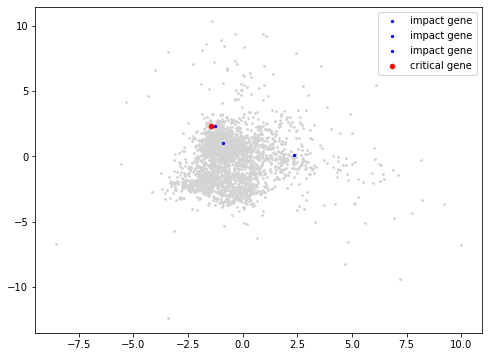

In [485]:
plot_critical_genes(processed_emb, '60', '61', lr_critical_genes[1], 'ENSG00000107338')

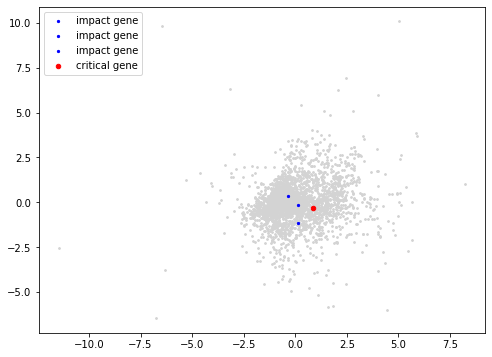

In [482]:
plot_critical_genes(processed_emb, '50', '40', rf_critical_genes[1], 'ENSG00000107338')

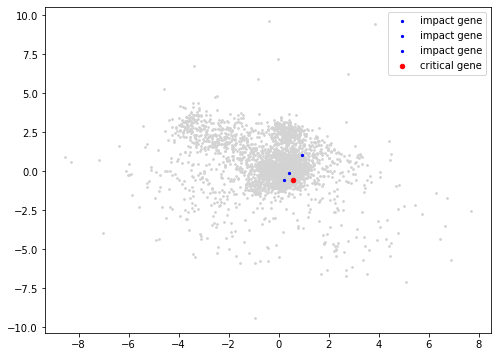

In [484]:
plot_critical_genes(processed_emb, '22', '8', xgb_critical_genes[1], 'ENSG00000107338')